# KNN Regression Practice 
## using cancer data set to predict Mortality rate 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
cancer <- read_csv("data_2/US_county_cancer_data.csv") %>% 
        select(TARGET_deathRate, povertyPercent)

head(cancer)

Rows: 3047 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): binnedInc, Geography
dbl (32): avgAnnCount, avgDeathsPerYear, TARGET_deathRate, incidenceRate, me...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TARGET_deathRate,povertyPercent
<dbl>,<dbl>
164.9,11.2
161.3,18.6
174.7,14.6
194.8,17.1
144.4,12.5
176.0,15.6


In [4]:
set.seed(123) 

cancer_split <- initial_split(cancer, prop = 0.70, strata = TARGET_deathRate)
cancer_train <- training(cancer_split)
cancer_test <- testing(cancer_split)

In [7]:
# create recipe and standardize data 
cancer_recipe <- recipe(TARGET_deathRate ~., data = cancer_train) %>% 
        step_normalize(all_predictors())

cancer_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
            set_engine("kknn") %>% 
            set_mode("regression") 

# create cross validation 
cancer_vfold <- vfold_cv(cancer_train, v = 5, strata = TARGET_deathRate) 
gridvals <- tibble(neighbors = seq(1, 200)) 

cancer_fit <- workflow() %>% 
        add_recipe(cancer_recipe) %>% 
        add_model(cancer_model) %>% 
        tune_grid(resamples = cancer_vfold, grid = gridvals) %>% 
        collect_metrics()
cancer_fit


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,39.43433769,5,0.630238363,Preprocessor1_Model001
1,rsq,standard,0.03453467,5,0.006707972,Preprocessor1_Model001
2,rmse,standard,35.01571286,5,0.410446254,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
199,rsq,standard,0.1742194,5,0.02249880,Preprocessor1_Model199
200,rmse,standard,25.3149960,5,0.25660750,Preprocessor1_Model200
200,rsq,standard,0.1741975,5,0.02265038,Preprocessor1_Model200


In [9]:
cancer_min <- cancer_fit %>% 
   filter(.metric == "rmse") %>% 
   arrange(mean) %>% 
   head(1)

cancer_min

k_min <- cancer_min %>% 
         pull(neighbors)

k_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
170,rmse,standard,25.30122,5,0.2731677,Preprocessor1_Model170


[1] 170

In [11]:
# create new model with found k_value
cancer_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
            set_engine("kknn") %>% 
            set_mode("regression") 

cancer_best_fit <- workflow() %>% 
        add_recipe(cancer_recipe) %>% 
        add_model(cancer_best_spec) %>% 
        fit(data = cancer_train) 

cancer_summary <- predict(cancer_best_fit, cancer_test) %>% 
                bind_cols(cancer_test) %>%
                metrics(truth = TARGET_deathRate, estimate = .pred) 
cancer_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,24.4316618
rsq,standard,0.2239827
mae,standard,18.7206473


##### RMSPE 24.24% 

In [18]:
cancer_preds <- cancer_best_fit |>
    predict(cancer_train) |>
    bind_cols(cancer_train)

cancer_preds

.pred,TARGET_deathRate,povertyPercent
<dbl>,<dbl>,<dbl>
170.9253,121.4,12.7
183.1335,128.0,17.0
177.0329,153.0,15.3
⋮,⋮,⋮
167.0059,208.3,10.5
184.0859,215.9,17.4
173.2959,213.6,13.9


##### RMSE 25.14% 

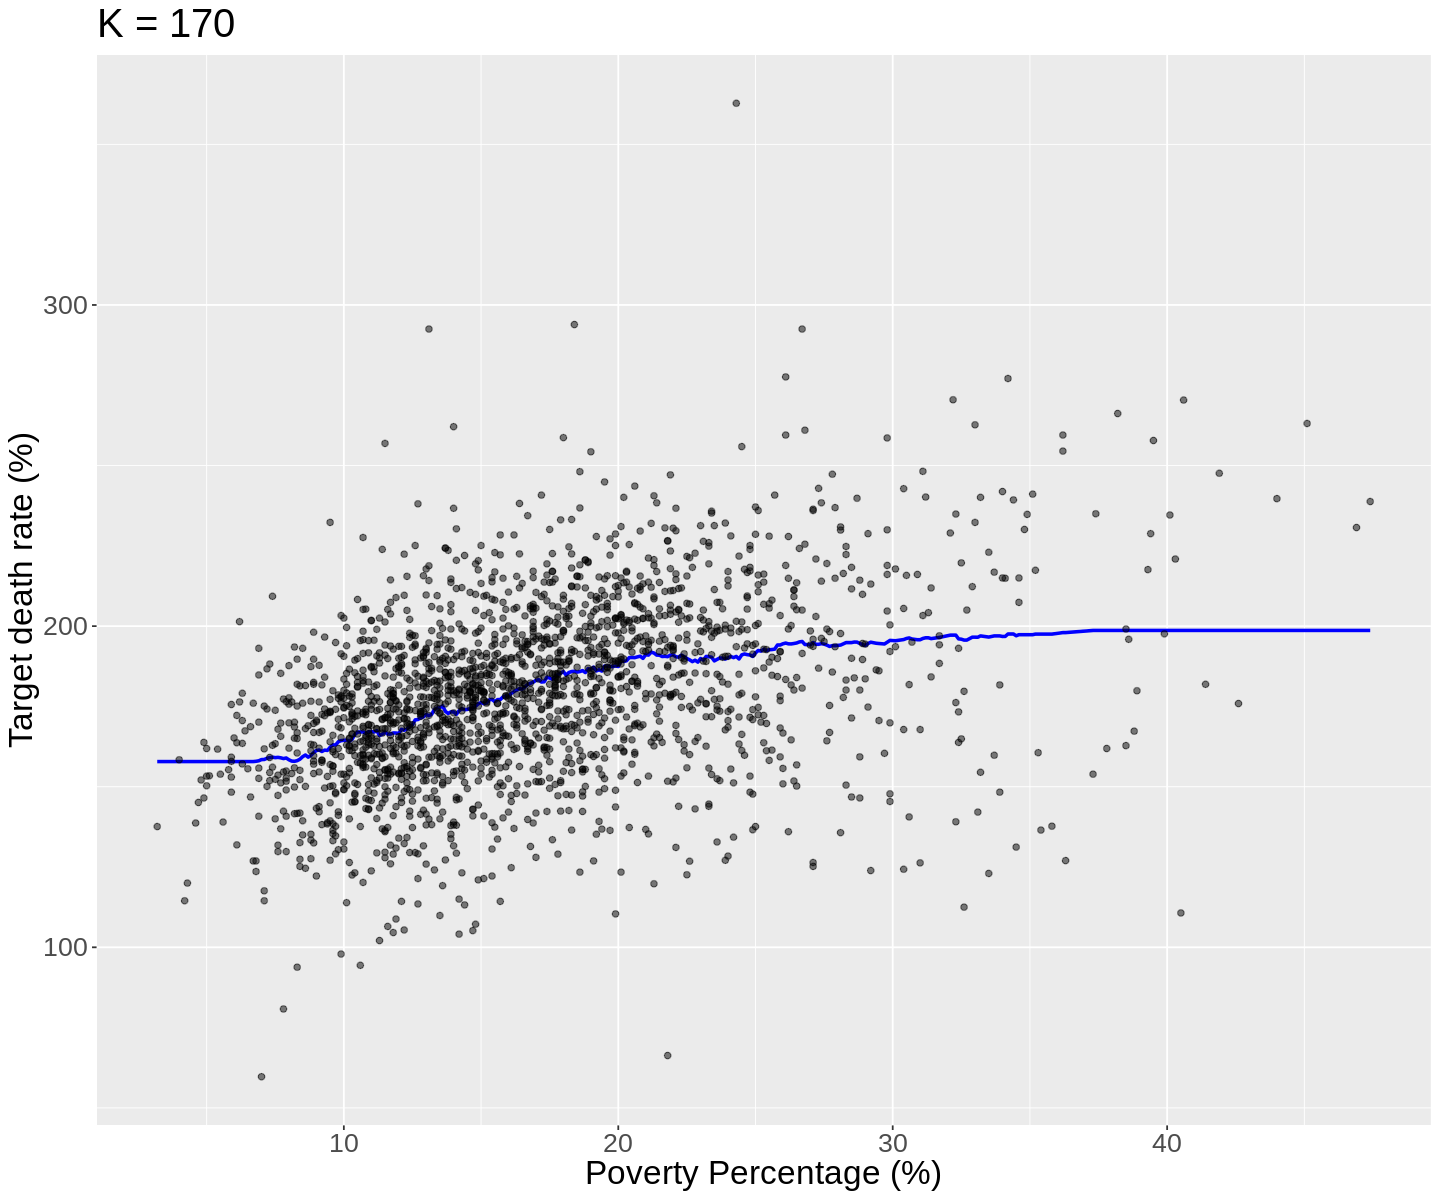

In [20]:
options(repr.plot.width = 12, repr.plot.height = 10) 

cancer_plot_2 <- 
    ggplot(cancer_preds, aes(x = povertyPercent, y = TARGET_deathRate)) +
    geom_line(aes(x = povertyPercent, y = .pred), color = "blue", size = 1) +
    geom_point(alpha = 0.5) +
    labs(x = "Poverty Percentage (%)",
         y = "Target death rate (%)",
         title = paste0("K = ", k_min)) +
    theme(text = element_text(size = 20))

cancer_plot_2